# ECS7024 Statistics for Artificial Intelligence and Data Science

## Georgia Gunson

## Aims and Outline

 1. Section 1: Data Preparation
       1. Assigning bridge age
       1. Reducing categories
       1. Defining bridge condition
       1. Removing outliers

 2. Section 2: Exploratory Analysis
       1. Continuous variables
       1. Categorical variables
       1. Preliminary conclusions
 3. Section 3: Regression Modelling
       1. Data preparation
       1. Interpreting the results
       1. Evaluating the model
       1. Conclusions
     
     

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Introduction

The dataset used in this report is sourced from the US National Bridge Inspection, collated by the Federal Highways Agency (FHWA) and can be found in the [National Bridge Inspection](https://www.fhwa.dot.gov/bridge/nbi/ascii.cfm) section of the FHWA's web site. For the purpose of this report, we focus on the state of Texas, USA, on a subset of columns of interest to our analysis. Predominantly, the columns below:


| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Year           | The year the bridge was built                             | continuous | 
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

## Section 1: Data Preparation

The aim of this section is to prepare our data for downstream analysis. Here, we will look to simplify categories for our variables of interest, exclude outliers and generate a measure of bridge condition that is compatible for regression analysis.

In [2]:
# Read in the data

# Set dictionary for rating data types in order 
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# Specify types for columns
types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type}


# Read in the data
bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')

### Assigning bridge age

To provides a variable we can use to elucidate any relationship between bridge age and bridge condition in our analysis, bridge age was calculated from the year the bridge was built. 

In [3]:
# Assign new column of bridge age 
bridges = bridges.assign(Age = 2023 - bridges['Year'])

In Figure 1, the distribution of bridge ages appears multimodal with a positive skew. One consideration for our data is the presence of historic bridges. Historic bridges may have unique characteristics and maintenance practices as a result of the advancement of engineering materials and technology over time. Inclusion in our analysis could affect our investigation into the relationship between bridge age and bridge condition as historic engineering practices may also influence bridge condition. To prevent this, bridges with a value of 'Register', in the Historic column, were removed from analysis. Very old bridges, defined as bridges older than the 80th percentile of the data, were also excluded from the analysis. This removed 7687 entries from the dataset.

**Figure 1.** The distribution of bridge age in years 

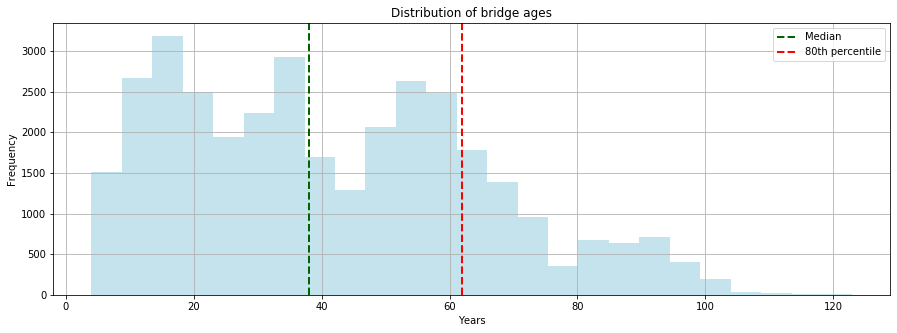

In [4]:
# Plot a histogram of the bridge age data
plt.figure(figsize=(15,5)) 
bridges['Age'].hist(bins=25, color='lightblue', alpha=0.7)

plt.title('Distribution of bridge ages')
plt.xlabel('Years')
plt.ylabel('Frequency')

# Add a line for median
plt.axvline(bridges['Age'].median(), color='darkgreen', linestyle='dashed', linewidth=2, label='Median')

# Add a line for 
plt.axvline(bridges['Age'].quantile(0.80), color='red', linestyle='dashed', linewidth=2, label='80th percentile')

plt.legend()

In [5]:
print('Bridge age at 80th percentile:', bridges['Age'].quantile(0.8))

Bridge age at 80th percentile: 62.0


In [6]:
# Remove bridges registered as historic from the dataset
bridges_df = bridges.loc[bridges['Historic']!= 'Register'].copy()

# Remove bridges older than 80th percentile age
bridges_df = bridges_df.loc[bridges_df['Age']< bridges_df['Age'].quantile(0.8)].copy()

# How many rows affected?
print(len(bridges)-len(bridges_df), 'rows were removed')

7687 rows were removed


### Reducing categories

The number of categories of 'Material' and 'Design' categorical were reduced to improve the interpretability of our analysis. Categories present in < 2% of the data were combined with the 'Other' category. For Material, the categories combined with 'Other' were 'Masonry' and 'Timber', observed in Table 1. For Design, in Table 2., categories combined were 'Arch', 'Frame', 'Truss', 'Movable', 'Suspension'.

**Table 1.** The counts and relative frequencies, as percentages, of categories of dominant bridge material

In [7]:
# Get value counts for 'Material' categories
mat_value_counts = bridges_df['Material'].value_counts()

# Calculate relative frequencies
mat_rel_freq = (mat_value_counts / len(bridges)) * 100

# Create table of counts and percentages
material_data = pd.DataFrame({'Count': mat_value_counts, 'Relative Frequency (%)': round(mat_rel_freq,2)})

# Show table
material_data

,Count,Relative Frequency (%)
Concrete,21487,62.66
Steel,4685,13.66
Timber,394,1.15
Other,39,0.11
Masonry,1,0.00


**Table 2.** The counts and relative frequencies, as percentages, of categories of bridge design

In [8]:
# Get value counts for 'Design' categories
des_value_counts = bridges_df['Design'].value_counts()

# Calculate relative frequencies
des_rel_freq = (des_value_counts / len(bridges)) * 100

# Create table of counts and percentages
design_data = pd.DataFrame({'Count': des_value_counts, 'Relative Frequency (%)': round(des_rel_freq,2)})

# Show table
design_data

,Count,Relative Frequency (%)
Beam,23571,68.73
Slab,1708,4.98
Other,1186,3.46
Arch,82,0.24
Frame,36,0.10
Truss,13,0.04
Movable,7,0.02
Suspension,3,0.01


In [9]:
# Copy the data to reassign and recode variables separately
bridge_recat = bridges_df.copy()

# Reassign 'Masonry' and 'Timber' to 'Other'
bridge_recat['Material'] = bridge_recat['Material'].replace({'Timber': 'Other', 'Masonry': 'Other'})

# Reassign 'Arch', 'Frame', 'Truss', 'Movable', 'Suspension' to 'Other'
bridge_recat['Design'] = bridge_recat['Design'].replace({'Arch':'Other', 'Frame':'Other', 
                                                         'Truss':'Other', 'Movable': 'Other', 
                                                         'Suspension':'Other'})

### Defining bridge condition

To understand how different variables may predict bridge condition, we will perform regression analysis on the dataset. In preparation, a new variable, 'current condition', was created as a combined single measure of bridge quality. The 'current condition' is  derivative of the deck, superstructure and substructure ratings. Each rating was assigned an integer score ranging from 0 (for 'Failed') to 7 (for 'Excellent'), listed below. The three rating scores were summed per entry to generate the 'current condition'. This approach results in a continuous variable that quantifies bridge quality and is suitable for regression analysis.
* Excellent = 7
* Very Good = 6
* Good = 5
* Satisfactory = 4
* Serious = 3
* Critical = 2
* Failing = 1
* Failed = 0

In [10]:
# Dictionary mapping compatible for Deck_rating, Superstr_rating & Substr_rating
rating_dict = {'Excellent':7, 'Very Good':6, 'Good':5, 'Satisfactory':4,
                    'Serious':3, 'Critical':2, 'Failing':1, 'Failed':0}

# Map 3 categorical variables to integers in the dictionary
bridge_recat['Deck_rating'] = bridge_recat['Deck_rating'].map(rating_dict)
bridge_recat['Superstr_rating'] = bridge_recat['Superstr_rating'].map(rating_dict)
bridge_recat['Substr_rating'] = bridge_recat['Substr_rating'].map(rating_dict)

# Sum the three ratings together to get current condition, do not account for missing data
bridge_recat['Current_condition'] = bridge_recat['Deck_rating'] + bridge_recat['Superstr_rating'] + bridge_recat['Substr_rating']

It is important to identify bridges with missing deck, superstructure and substructure ratings as this would result in a lower overall current condition score and consequently may skew analysis on relationships between bridge condition and variables of interest. To account for this, bridges with missing data in any of the three ratings were removed from downsteam analysis. 

**Table 6.** A preview of the data where the current condition of the bridge is missing. The current condition was set to not account for missing data for ease of identification.

In [11]:
# Get a preview of how missing data looks
bridge_recat.loc[bridge_recat['Current_condition'].isna(), ['Deck_rating', 'Superstr_rating', 'Substr_rating', 'Current_condition']].head()

,Deck_rating,Superstr_rating,Substr_rating,Current_condition
Structure_id,,,,
010600AA0101002,5.0,4.0,NaN,NaN
010600AA0105001,5.0,4.0,NaN,NaN
010600AA0143001,5.0,4.0,NaN,NaN
010600AA0173001,NaN,4.0,NaN,NaN
010600AA0194002,NaN,4.0,NaN,NaN


In [12]:
# Filter NA values out, current condition will be NA if any of the ratings are NA 
bridge_tidy_df = bridge_recat.loc[bridge_recat['Current_condition'].isna()==False].copy()

### Removing outliers

The distributions of both the average daily traffic and the percentage of bridge traffic composed of trucks are both highly positively skewed with a large range of frequencies, Figure 2. This large range of frequencies could possibly be explained by differences in traffic between rural and urban areas. However, focussing on the majority of the data, situated mainly in the left side of the distribution, could reveal more meaningful insight into the relationships with bridge condition. Values in the extreme high ranges in the right tail may also be outliers. Taking this into consideration, data in the top 10 percentile of both average daily traffic and truck traffic have been removed from analysis, this will also reduce the positive skew.

**Figure 2.** The distributions of average daily traffic and the percentages of truck traffic. In the right-side plots, frequency has been converted to a base 10 logarithmic scale for a clearer visualisation of the large range in frequencies.

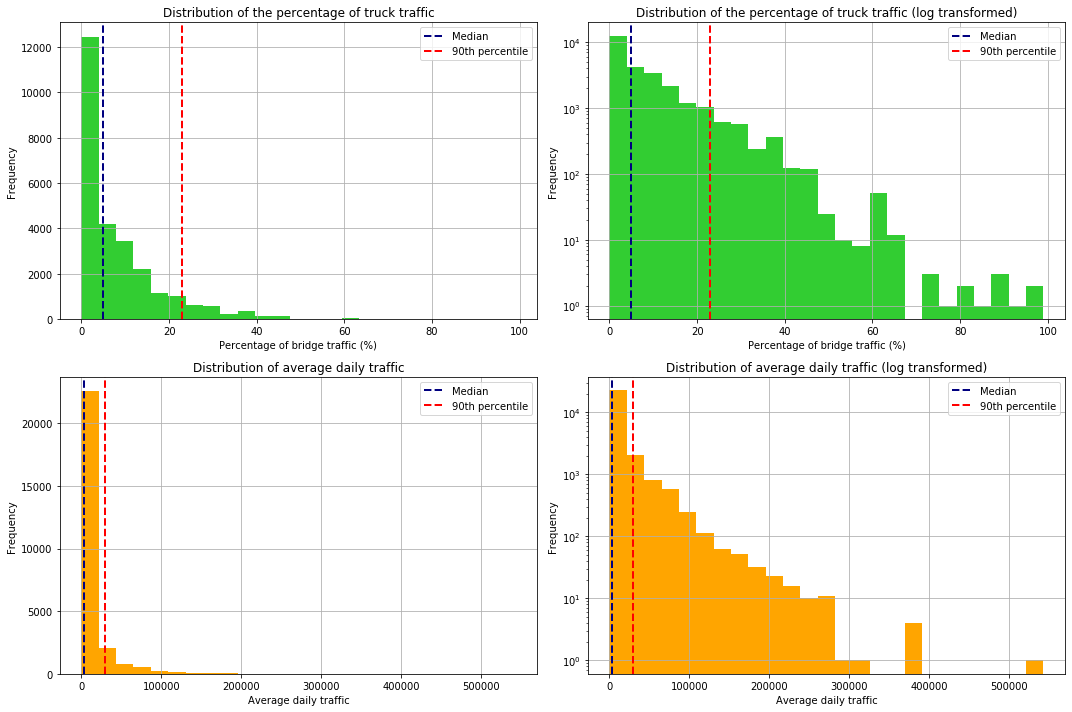

In [13]:
# Set 4 panel and fig size
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trucks_percent histogram
bridge_recat['Trucks_percent'].hist(ax=axes[0, 0], color='limegreen', bins=25)
axes[0, 0].set_title('Distribution of the percentage of truck traffic')
# Add median line
axes[0, 0].axvline(bridges['Trucks_percent'].median(), color='navy', linestyle='dashed', linewidth=2, label='Median')
axes[0, 0].axvline(bridges['Trucks_percent'].quantile(0.90), color='red', linestyle='dashed', linewidth=2, label='90th percentile')
axes[0, 0].set_xlabel('Percentage of bridge traffic (%)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Trucks_percent log transformed histogram 
bridge_recat['Trucks_percent'].hist(ax=axes[0, 1], color='limegreen', bins=25, log=True)
axes[0, 1].set_title('Distribution of the percentage of truck traffic (log transformed)')
# Add median line
axes[0, 1].axvline(bridges['Trucks_percent'].median(), color='navy', linestyle='dashed', linewidth=2, label='Median')
axes[0, 1].axvline(bridges['Trucks_percent'].quantile(0.90), color='red', linestyle='dashed', linewidth=2, label='90th percentile')
axes[0, 1].set_xlabel('Percentage of bridge traffic (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# AverageDaily histogram
bridge_recat['AverageDaily'].hist(ax=axes[1, 0], color='orange', bins=25)
axes[1, 0].set_title('Distribution of average daily traffic')
# Add median line
axes[1, 0].axvline(bridges['AverageDaily'].median(), color='navy', linestyle='dashed', linewidth=2, label='Median')
axes[1, 0].axvline(bridges['AverageDaily'].quantile(0.90), color='red', linestyle='dashed', linewidth=2, label='90th percentile')
axes[1, 0].set_xlabel('Average daily traffic')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# AverageDaily log transformed histogram
bridge_recat['AverageDaily'].hist(ax=axes[1, 1], color='orange', bins=25, log=True)
axes[1, 1].set_title('Distribution of average daily traffic (log transformed)')
# Add median line
axes[1, 1].axvline(bridges['AverageDaily'].median(), color='navy', linestyle='dashed', linewidth=2, label='Median')
axes[1, 1].axvline(bridges['AverageDaily'].quantile(0.90), color='red', linestyle='dashed', linewidth=2, label='90th percentile')
axes[1, 1].set_xlabel('Average daily traffic')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

# Show the panel of 4 plots
plt.tight_layout()
plt.show()


In [14]:
# Remove values above 90th percentile for both variables
bridge_adj = bridge_tidy_df.loc[bridge_tidy_df['AverageDaily']< bridge_tidy_df['AverageDaily'].quantile(0.9)].copy()
bridge_adj = bridge_adj.loc[bridge_adj['Trucks_percent']< bridge_tidy_df['Trucks_percent'].quantile(0.9)]

## Section 2: Exploratory Analysis

The aim of this section is to begin exploring the relationship between the five predictor variables and the current condition of a bridge.

In [15]:
# Remove excess columns to focus on variables of interest
bridge_slice = bridge_adj.loc[:,['AverageDaily', 'Trucks_percent','Material', 'Design', 'Age', 'Current_condition']].copy()

### Continuous variables

First we explore the continuous variables of our dataset and their relationship to the current condition. Bridge age and current condition, while both discrete variables, are being treated as continuous for this comparison. 

The scatter plots in Figure 3 do not suggest a strong relationship between bridge traffic and the current condition, either as a measure of daily average traffic or percentage of trucks. This is supported by weak correlations observed in Table 7. The average daily traffic shows a very small negative correlation with the current condition with a sample correlation coefficient (r) of -0.02. The percentage of traffic composed of trucks has a very weak positive correlation, r = 0.03, with the current condition. A correlation coefficient close to 0 suggests an indepenent relationship between bridge average daily traffic, truck traffic and bridge condition.

**Figure 3.** Comparison of average daily traffic and truck traffic with bridge current condition

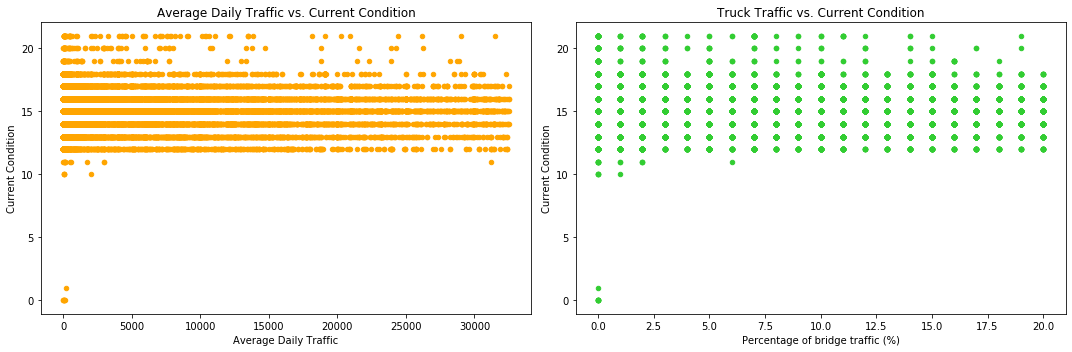

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Average daily traffic scatter plot
ax1 = bridge_slice.plot(kind='scatter', x='AverageDaily', y='Current_condition', color='orange', ax=axes[0])
ax1.set_xlabel('Average Daily Traffic')
ax1.set_ylabel('Current Condition')
ax1.set_title('Average Daily Traffic vs. Current Condition')

# Plot 2: Truck traffic scatter plot
ax2 = bridge_slice.plot(kind='scatter', x='Trucks_percent', y='Current_condition', color='limegreen', ax=axes[1])
ax2.set_xlabel('Percentage of bridge traffic (%)')
ax2.set_ylabel('Current Condition')
ax2.set_title('Truck Traffic vs. Current Condition')

# Display plots
plt.tight_layout()
plt.show()

**Table 7.** Correlation matrix of the average daily traffic, the percentage of traffic composed of trucks, bridge age and the current condition

In [17]:
bridge_slice[['Current_condition', 'Trucks_percent', 'AverageDaily', 'Age']].corr().round(2)

,Current_condition,Trucks_percent,AverageDaily,Age
Current_condition,1.00,0.03,-0.02,-0.55
Trucks_percent,0.03,1.00,0.23,0.13
AverageDaily,-0.02,0.23,1.00,0.08
Age,-0.55,0.13,0.08,1.00


The correlation matrix in Table 7 observes a sample correlation coefficient (r) of 0.23 between the percentage of traffic composed of trucks and the average daily traffic. This would indicate a weak positive correlation between the two variables, suggesting that as the average daily traffic increases, the percentage of traffic composed of trucks also increases. However, this correlation is weak and a dependent relationship is not observed in the scatter plot in Figure 4.

**Figure 4.** The relationship between the average daily traffic and the percentage of traffic composed of trucks 

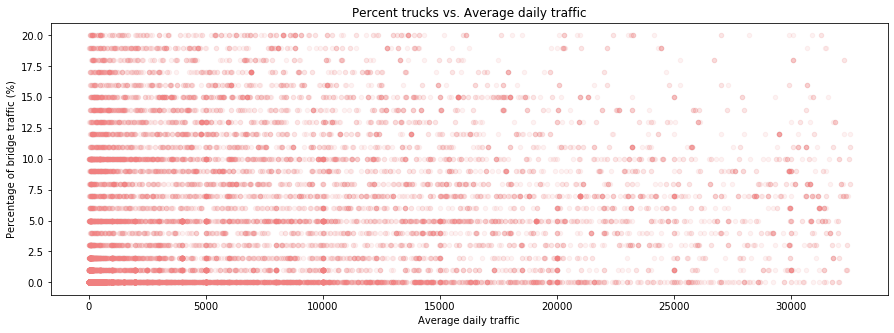

In [18]:
# Plot continuous variables against one another
ax = bridge_slice.plot(kind='scatter', x='AverageDaily', y='Trucks_percent', figsize=(15, 5), color='lightcoral', alpha=0.1)

# Set plot aesthetics
ax.set_xlabel('Average daily traffic')
ax.set_ylabel('Percentage of bridge traffic (%)')
ax.set_title('Percent trucks vs. Average daily traffic')

plt.show()

There appears to be an independent relationship between average daily traffic, the percentage of traffic made of trucks and bridge age. This is supported by weak positive correlations in Table 7 of r = 0.08, and r=0.13 for bridge age with average daily traffic and truck traffic respectively in combination with the scatter plots of Figure 5. However, there is a moderate negative correlation between bridge age and bridge condition with a sample correlation coefficient of -0.55. In Figure 5, you can see that as bridge age increases, the current condition tends to decrease.

**Figure 5.** Comparison of the age of bridges with current condition, average daily traffic and truck traffic

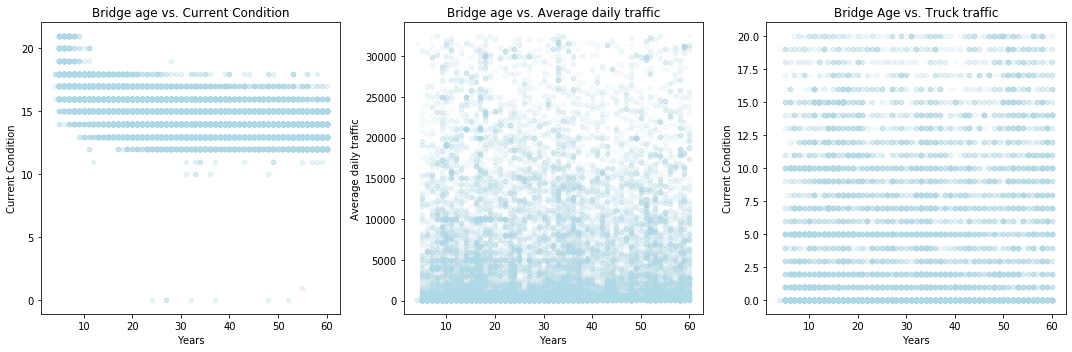

In [19]:
# Age plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Age vs current condition
ax1 = bridge_slice.plot(kind='scatter', x='Age', y='Current_condition', color='lightblue', ax=axes[0],alpha=0.3)
ax1.set_xlabel('Years')
ax1.set_ylabel('Current Condition')
ax1.set_title('Bridge age vs. Current Condition')

# Plot 2: Age vs average daily traffic
ax2 = bridge_slice.plot(kind='scatter', x='Age', y='AverageDaily', color='lightblue', ax=axes[1],alpha=0.1)
ax2.set_xlabel('Years')
ax2.set_ylabel('Average daily traffic')
ax2.set_title('Bridge age vs. Average daily traffic')

# Plot 3: Age vs truck traffic
ax3 = bridge_slice.plot(kind='scatter', x='Age', y='Trucks_percent', color='lightblue', ax=axes[2], alpha=0.1)
ax3.set_xlabel('Years')
ax3.set_ylabel('Current Condition')
ax3.set_title('Bridge Age vs. Truck traffic')

# Display plots
plt.tight_layout()
plt.show()


### Categorical variables

Next we explore to what extent the categorical variables, design and material, influence bridge condition. We will calculate and visualise probabilities to gain insight into whether different combinations of material and design are more or less likely to be associated with a particular bridge condition.

The probability distributions of Figure 7 enable us to evaluate the nature of the relationship between bridge condition and each categorical variable alone. 

**Material**: The most prevalent current condition for concrete material bridges was 15, with a probability of 0.32, closely followed by a probability of 0.24 for 16. While steel bridges had the highest probability at a condition rating of 13, with a probability of 0.27, and condition value 15 closely behind at 0.23. There are comparably small probabilities for high and low current condition ratings across each material. Thus, this data alone does not support a strong, direct relationship between the dominant bridge material and the current condition. Notably, the 'Other' material category demonstrates the widest range of probabilities across current condition ratings. This could reflect the diversity of the materials it encompasses and may provide evidence for an influence on current condition rating by bridge material. More analysis is required to form more definitive conclusions.

**Design**: Similar to the material category, the probability distributions of current condition by bridge design did not provide evidence to support a direct relationship. For 'Beam' design, the current condition with the highest probability was 15 at 0.32. This was followed by a probability of 0.22 for condition value 16. The 'Slab' design's most probable current condition was 15 at 0.28, with the second most probable rating of 16 at 0.17. Again, there were comparably small probabilities for high and low bridge condition ratings observed across all design categories. The 'Other' design showed the largest range in probabilities across current conditions. Further exploration is required to elucidate the nature of any indirect relationships with bridge condition.


**Figure 7.** Probability distributions of bridge material and design by current condition, plotted separately. Current condition value snot present in the dataset are not included in the plot. This plot accounts for the disparities in material frequency in our datastet.

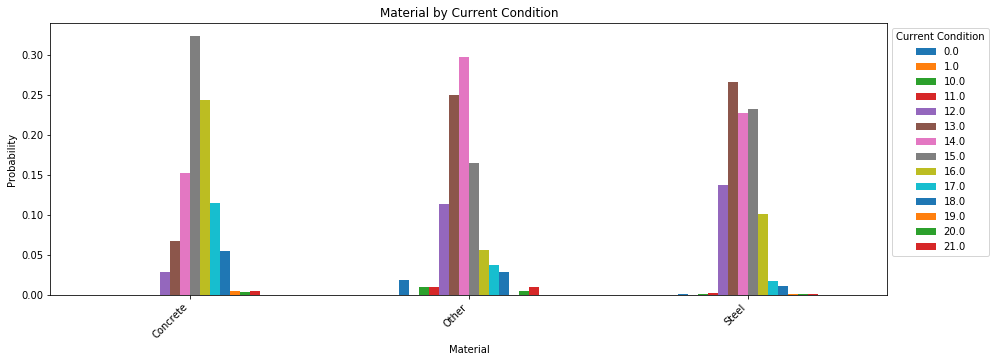

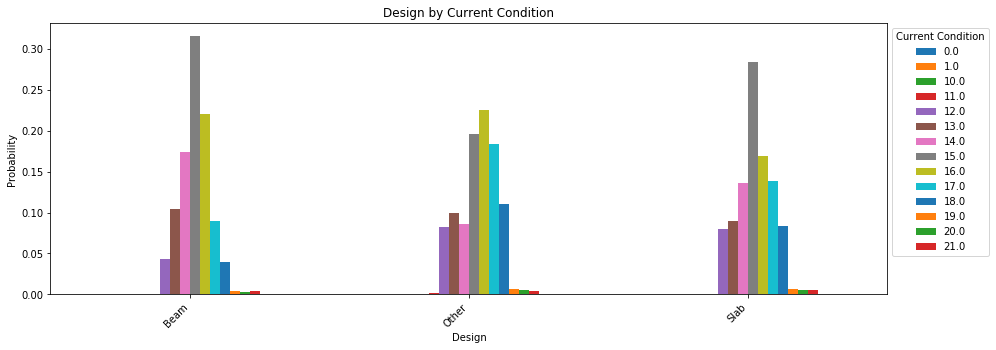

In [20]:
# Material vs Current condition
material_probs = pd.crosstab(bridge_slice['Material'], bridge_recat['Current_condition'], normalize='index')
# Get tidy for plotting
material_probs = material_probs.round(4)
ax = material_probs.plot(kind='bar', figsize=(15, 5))

# Set plot aesthetics
ax.set_xlabel('Material')
ax.set_ylabel('Probability')
ax.set_title('Material by Current Condition')
# Rotate axis tick labels for better visual
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Fiddle with legend label and position
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Current Condition')

# Display plot
plt.show()

# Design vs Current condition
design_probs = pd.crosstab(bridge_slice['Design'], bridge_recat['Current_condition'], normalize='index')
# Get tidy for plotting
design_probs = design_probs.round(4)

ax2 = design_probs.plot(kind='bar', figsize=(15, 5))

# Set plot aesthetics
ax2.set_xlabel('Design')
ax2.set_ylabel('Probability')
ax2.set_title('Design by Current Condition')
# Rotate axis tick labels for better visual
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

# Fiddle with legend lable and position
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Current Condition')

# Display plot
plt.show()


In Figure 8, we observe increases in the probabilities of current condition ratings 15-18 for Concrete-Beam, Concrete-Other and Concrete-Slab bridges between the joint and conditional probability heatmaps. This suggests that, given a specific bridge design, the likelihood of a current condition rating varies. Thus implying that bridge material and design interaction influences bridge condition. This is interaction is supported by observations across all material-design combinations. Most notably, Steel-Other bridges experience an increase in probability from 0.35% to 33.5% for a current condition rating of 12.0 when conditioned on bridge Design. 

**Figure 8.** Heatmaps of joint and conditional probabilities for bridge material, design and current condition. The colour scale represents the probabilities as percentages. The first heatmap shows the probabilities of obtaining a specific current condition given independent probabilities of bridge material and design. The second heatmap reveals the probabilities of observing specific current condition values, conditioned on the probability of a material given a specific design.

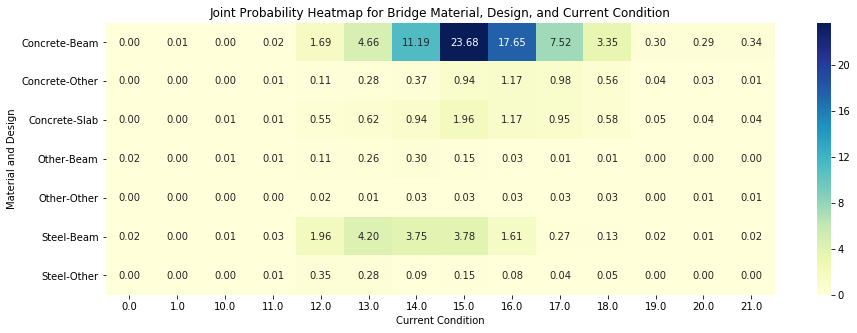

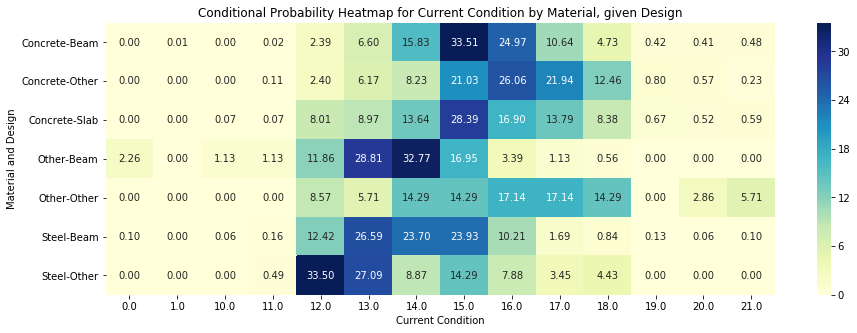

In [21]:
# Probability heatmaps for comparison

# Joint probability
# calculate probabilities of combinations of the design and material for current conditions
joint_probabilities = pd.crosstab([bridge_slice['Material'], bridge_slice['Design']], bridge_slice['Current_condition'], normalize='all')

# Create heatmap
plt.figure(figsize=(15, 5))
ax = sns.heatmap(joint_probabilities * 100, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Joint Probability Heatmap for Bridge Material, Design, and Current Condition")
plt.xlabel("Current Condition")
plt.ylabel("Material and Design")

# Adjust the y-axis limits to prevent cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

# Conditional probability
cond_by_mat_given_des = pd.crosstab([bridge_slice['Material'], bridge_slice['Design']], bridge_slice['Current_condition'], normalize='index')

plt.figure(figsize=(15, 5))
ax = sns.heatmap(cond_by_mat_given_des * 100, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Conditional Probability Heatmap for Current Condition by Material, given Design")
plt.ylabel("Material and Design")
plt.xlabel("Current Condition")

# Adjust the y-axis limits to prevent cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

The corrosion of materials over time may occur at different rates and thus have different affects on bridge condition. In order to explore the interaction between bridge material, age and current condition, for interpretability, age has been split into intervals stated below:
* 0-14 years
* 15-29 years
* 30-44 years
* 45-60 years
* 61+ years


In Figure 9 we see differences in joint and conditional probabilities for bridge condition ratings by material and age. For example, the likelihood of a rating of 13 for the current condition of steel bridges aged 45-60 increases drastically from 0.98% to 35.17% when probability is conditioned on both material and age. This suggests that the effect of material on bridge condition may also depend on bridge age. 

In [22]:
# Group age into intervals to compare
# Define intervals
age_intervals = [0, 15, 30, 45, 60, float('inf')]  # Customize the intervals as needed

# Define labels for intervals
age_labels = ['(0-14)', '(15-29)', '(30-44)', '(45-60)', '(61+)']

# Create a new column with the age intervals
bridge_slice['AgeGroup'] = pd.cut(bridge_slice['Age'], bins=age_intervals, labels=age_labels)

**Figure 9.** Heatmaps of joint and conditional probabilities for bridge material, age and current condition. The colour scale represents the probabilities as percentages. The first heatmap shows the probabilities of obtaining a specific current condition given independent probabilities of bridge material and age. The second heatmap reveals the probabilities of observing specific current condition values, conditioned on the probability of a material given a specific age.

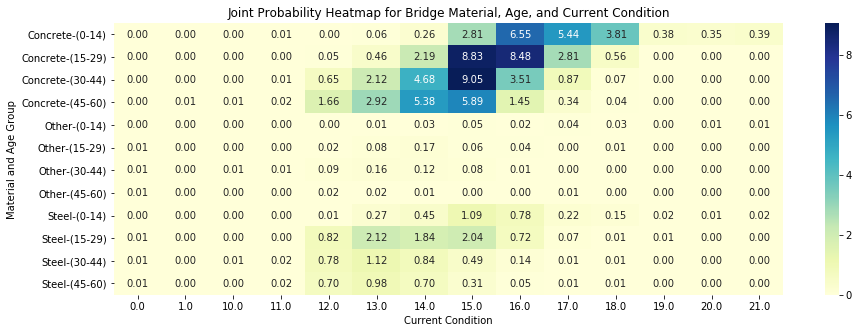

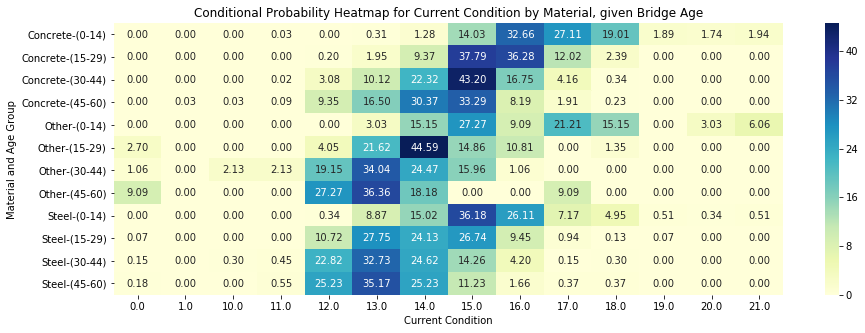

In [23]:
# Probability heatmaps for comparison of bridge age and bridge material

# Joint probability
# calculate probabilities of combinations of the material and age for current conditions
joint_probabilities = pd.crosstab([bridge_slice['Material'], bridge_slice['AgeGroup']], bridge_slice['Current_condition'], normalize='all')

# Create heatmap
plt.figure(figsize=(15, 5))
ax = sns.heatmap(joint_probabilities * 100, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Joint Probability Heatmap for Bridge Material, Age, and Current Condition")
plt.xlabel("Current Condition")
plt.ylabel("Material and Age Group")

# Adjust the y-axis limits to prevent cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

# Conditional probability
# calculate conditional probabilities of current by material given age group
cond_by_mat_given_age = pd.crosstab([bridge_slice['Material'], bridge_slice['AgeGroup']], bridge_slice['Current_condition'], normalize='index')

plt.figure(figsize=(15, 5))
ax = sns.heatmap(cond_by_mat_given_age * 100, annot=True, cmap="YlGnBu", cbar=True, fmt=".2f")
plt.title("Conditional Probability Heatmap for Current Condition by Material, given Bridge Age")
plt.ylabel("Material and Age Group")
plt.xlabel("Current Condition")

# Adjust the y-axis limits to prevent cutoff
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### Preliminary conclusions

From the exploratory analysis, we can make some preliminary conclusions. The dataset does not provide support for a direct relationship between the average daily traffic or the percentage of traffic composed of trucks and the bridge condition. Furthermore, the data does not indicate a relationship between the age of a bridge and the traffic metrics; average daily traffic or the percentage of traffic composed of trucks. However, a moderate negative relationship was identified between bridge age and bridge condition. This suggests that older bridges will be in worse condition and is compatible with the postulate that bridge material will corrode and deteriorate over time. Furthermore, the combination of bridge material and age, when conditioned together, also causes variation in the probabilities of bridge condition ratings. When bridges are newly constructed, it is expected that the difference in bridge condition between materials would be neglible. Our findings shed light on a possible divergence of differences in bridge condition over time based on bridge material.

Our data suggests that bridge material and design do not exhibit direct relationships with bridge condition. However, the  likelihood of specific condition ratings appears to differ when material and design probabilities are conditioned together,  implying an interaction or dependent relationship between bridge material and design that influences bridge condition.

It is important to acknowledge that the analysis has not explored the relationship between bridge traffic and design or material in relation to bridge condition. This could be an avenue for future analysis, which could offer additional insights into the factors influencing bridge condition.


## Section 3: Regression Modelling

In this section, we will implement linear regression to explore how the variables of interest influence bridge condition. Our predictor variables for this model are the average daily traffic, the percentage of truck traffic, bridge age, bridge material, and bridge design. The model uses these variables to predict variation in a target variable, which, in this context, is the current condition of bridges. Our aim is to evaluate the model's efficacy in explaining variations in bridge condition and to understand the relationships between each variable and the current condition, using the model's coefficients.







### Data preparation

To incorporate categorical variables into a linear regression model, they must be converted into a numeric format. We do this by creating 'dummy' variables, which are encodes them with a number. Materal and design have been converted into dummy variables for this purpose. When encoding to a numeric dummy variable, the first category is used as a reference from which to compare the other categories. For material, this reference category was 'Concrete'. For design, this reference category was 'Slab'.

In [24]:
# Change categorical predictors e.g. material, design to dummy variables 
# Copy dataframe to recode variables in
bridge_lin_reg = bridge_slice.copy()

# Drop age group
bridge_lin_reg = bridge_lin_reg.drop(['AgeGroup'], axis=1)

# Convert to dummy variables 
design_dummies = pd.get_dummies(bridge_slice['Design'], prefix='Design', drop_first=True)
material_dummies = pd.get_dummies(bridge_slice['Material'], prefix='Material', drop_first=True)

# Replace values 
bridge_lin_reg['Design'] = design_dummies
bridge_lin_reg['Material'] = material_dummies

The coefficients in a linear regression model, called Betas, indicate how much the target variable (current condition) is expected to change for a one unit change in the predictor variable. The different ranges of our predictor variables, e.g. average daily traffic and age, can make interpretation of the model coefficients difficult to compare.  In order to accurately compare Beta coefficients, it is necessary to standardise the ranges of our predictors. For our analysis, we standardised the average daily traffic, the percentage of trucks and age of bridges to account for these difference in ranges.

In [25]:
# Standardise variables with different ranges e.g. AverageDaily, Trucks_percent and Age
bridge_lin_reg[['AverageDaily', 'Trucks_percent', 'Age']] = StandardScaler().fit_transform(bridge_lin_reg[['AverageDaily', 'Trucks_percent', 'Age']])

In [26]:
# Convert to numpy array
# Get predictors
X = bridge_lin_reg[['AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Age']].values
# Get target variable
y = bridge_lin_reg['Current_condition'].values

In [27]:
# Perform regression
reg = LinearRegression().fit(X, y)

# Get coefficients and predictor names (to not lose track)
coefficients = reg.coef_
predictor_names = ['AverageDaily', 'Trucks_percent', 'Material', 'Design', 'Age']

# Put in table
coef_df = pd.DataFrame({'Predictor': predictor_names, 'Coefficient': coefficients})

### Interpreting the results

The R2 coefficient, known as the coefficient of determination, measures how well a linear regression model fits the data and is one method to evaluate the model performance. The value of R2 ranges from 0 to 1, with 1 being a perfect prediction and 0 showing that the model does not predict the target variable.

In [28]:
print('The R2 coefficient of determination is', reg.score(X,y).round(2) )
print('The intercept is',reg.intercept_.round(2) )

The R2 coefficient of determination is 0.32
The intercept is 15.09


The R2 coefficient of determination for our model was 0.32. This indicates that approximately 32% of the variation in the current bridge condition can be explained by the predictor variables included in our linear regression model. This suggests that there are other unaccounted for factors or variation contributing to the remaining 68% of variation in bridge condition. This could be due to other predictor variables that are not included in our regression model.

The intercept for our model was 15.09. This value represents the predicted value of the target variable, current condition, when all of the predictor variables (average daily traffic, percentage of trucks, bridge age, bridge material, and bridge design) are 0 i.e. when all have no impact on the current condition.


**Table 8.** Table of Beta coefficients per each predictor variable from the linear regression model.

In [29]:
coef_df.round(2)

,Predictor,Coefficient
0,AverageDaily,0.01
1,Trucks_percent,0.15
2,Material,-1.30
3,Design,0.22
4,Age,-0.88


In [30]:
# calculate the change in the target values as a percentage of its range
# that would result from the changing each of the predictor variables over its range

# Get coefficients, probably a better way but I get the predictors confused
beta_AverageDaily = coef_df[coef_df['Predictor'] == 'AverageDaily']['Coefficient'].values[0]
beta_Trucks_percent = coef_df[coef_df['Predictor'] == 'Trucks_percent']['Coefficient'].values[0]
beta_Material = coef_df[coef_df['Predictor'] == 'Material']['Coefficient'].values[0]
beta_Design = coef_df[coef_df['Predictor'] == 'Design']['Coefficient'].values[0]
beta_Age = coef_df[coef_df['Predictor'] == 'Age']['Coefficient'].values[0]

# Get ranges for standardized predictors
average_daily_range = bridge_lin_reg['AverageDaily'].quantile(0.9) - bridge_lin_reg['AverageDaily'].quantile(0.1)
trucks_percent_range = bridge_lin_reg['Trucks_percent'].quantile(0.9) - bridge_lin_reg['Trucks_percent'].quantile(0.1)
age_range = bridge_lin_reg['Age'].quantile(0.9) - bridge_lin_reg['Age'].quantile(0.1)

# Calculate the changes in the target variable (Current_condition) as a percent of its range
rate_range = bridge_lin_reg['Current_condition'].quantile(0.9) - bridge_lin_reg['Current_condition'].quantile(0.1)

AverageDaily_cond_change = (100 * (beta_AverageDaily * average_daily_range) / rate_range)
Trucks_percent_cond_change = (100 * (beta_Trucks_percent * trucks_percent_range) / rate_range)
Age_cond_change = (100 * (beta_Age * age_range) / rate_range)


#### Average daily traffic

In [31]:
print ('The change in current condition (as a percent of its range) given by the coefficient of the average daily traffic (over its range) was %4.1f percent.'
       %(AverageDaily_cond_change))

The change in current condition (as a percent of its range) given by the coefficient of the average daily traffic (over its range) was  0.4 percent.


For each unit increase in the average daily traffic, our model predicts the current condition to change by 0.4 percent of the range of current condition values in the dataset. This suggests that changes in average daily traffic have a relatively small effect on the bridge condition, accounting for only 0.4 percent of the overall variation in current condition ratings across the data. 

#### The percentage of traffic made of trucks

In [32]:
print ('The change in Current Condition (as a percent of its range) given by the coefficient of the percentage of traffic made of trucks (over its range) is %4.1f percent.'
       % (Trucks_percent_cond_change))

The change in Current Condition (as a percent of its range) given by the coefficient of the percentage of traffic made of trucks (over its range) is  9.0 percent.


In [33]:
print("The coefficient of the percentage of traffic made of trucks was:", beta_Trucks_percent.round(2))

The coefficient of the percentage of traffic made of trucks was: 0.15


For each unit increase in the percentage of traffic made of trucks, our model predicts the current condition to change by 9.0 percent of the range of current condition values in the dataset. This suggests that changes in truck traffic has a small effect on the bridge condition, accounting for 9 percent of the overall variation in current condition ratings across the data. The coefficient was positive, suggesting the bridge condition is better when truck traffic is greater. 

#### Material

In [34]:
print("The coefficient of bridge material was:", beta_Material.round(2))

The coefficient of bridge material was: -1.3


When the material category was encoded to a numeric dummy variable, 'Concrete' was used as a reference, such that the coefficient is comparing the current condition for 'Steel' and 'Other' categories against the current condition of concrete bridges. The coefficient of -1.3 suggests that, compared to concrete, bridges made of steel or materials in the 'Other' category are associated with lower current conditions. While this does not quantify the effect of individual materials on bridge condition, it does show a relationship between bridge material and bridge condition and that, comparatively, concrete bridges are associated with higher ratings.

#### Design

In [35]:
print("The coefficient of bridge design was:", beta_Design.round(2))

The coefficient of bridge design was: 0.22


When the design category was encoded to a numeric dummy variable, 'Slab' was used as a reference. The coefficient of 0.22 compares the current conditions associated to slab design bridges with those in the 'Beam' and 'Other' categories. This value suggests that bridges with a beam or other design are associated with slightly higher current condition scores than the slab category. However, this association is small and does not support a strong direct relationship between bridge design and condition.

#### Age

In [36]:
print ('The change in Current Condition (as a percent of its range) given by the Age coefficient (over its range) is %4.1f percent.'
       % (Age_cond_change))

The change in Current Condition (as a percent of its range) given by the Age coefficient (over its range) is -60.9 percent.


In [37]:
print("The coefficient of bridge age was:", beta_Age.round(2))

The coefficient of bridge age was: -0.88


The model data suggests that for each unit increase in Age, the current condition is expected to decrease by approximately 60.9 percent. As the bridge ages, its current condition tends to deteriorate significantly. The negative coefficient of -0.88 indicates that there is a negative relationship between bridge age and current condition. 

### Evaluating the model

In linear regression, the differences between the predicited and actual values of our target variable (current condition) are referred to as 'residuals' or the 'errors'. The residuals are used to check the underlying assumptions of linear regression models i.e. that the relationship between predictor and target variables is linear. We can check if this relationship is linear or requires transformation by plotting the distribution of the residuals, Figure 10, and a scatter plot of predicted versus observed values, Figure 11.

The residuals follow a normal distribution in the histogram of Figure 10, providing evidence that the relationships we are analysing are linear. The scatter plot of Figure 11, shows many points equally distributed above and below the line of best fit, representing our linear regression model. In a well-fitted model, data points should cluster closely around this line. This scatter plot, incombination with an R2 coefficient of determination of 0.32, suggests that our model does explain most of the variation in our target variable, current condition. Further analysis is required in order to understand what other predictors or sources of variation may contributed to different bridge conditions.

**Figure 10.** Histogram of the distribution of the residuals. Residuals, also referred to as the errors, are the differences between the predicted and actual values of the target variable, which in this context is current condition. 

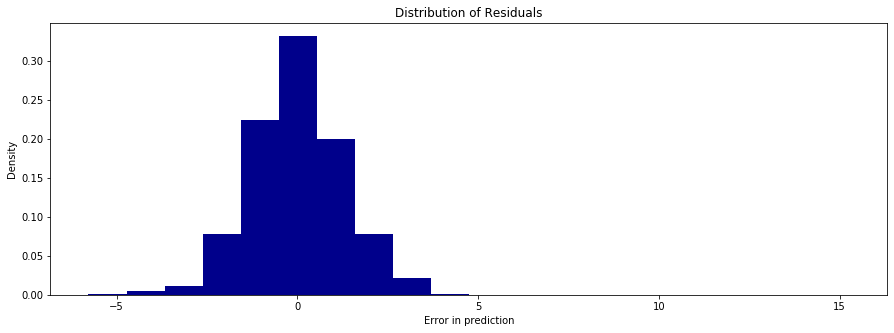

In [38]:
# Plot the residuals
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1, figsize=(15, 5))
residuals = y_hat - y
a1.hist(residuals, bins=20, density=True, color="darkblue")
a1.set_xlabel('Error in prediction')
a1.set_ylabel('Density')
a1.set_title('Distribution of Residuals')
plt.show()


**Figure 11.**  Scatter plot of the distribution of the residuals. Residuals, also referred to as the errors, are the differences between the predicted and actual values of the target variable, which in this context is current condition. The line of best fit is the regression line from our model. In a well-fitted model, data points should cluster closely around this line.

Text(0, 0.5, 'Actual Value')

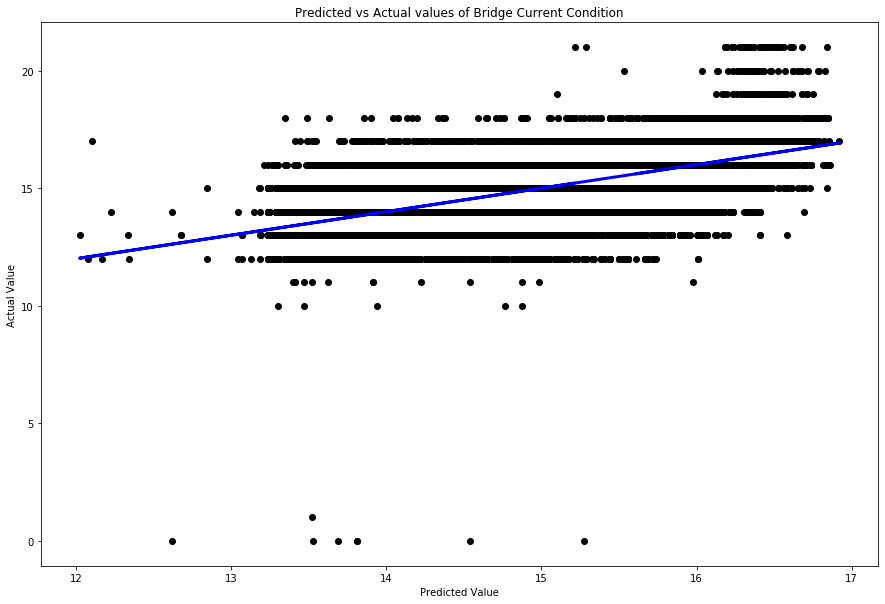

In [39]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(15,10))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)

a.set_title('Predicted vs Actual values of Bridge Current Condition')
a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

In [40]:
# Use predict() to return the predicted values of target variable
y_pred = reg.predict(X)

# Calculate the residuals
residuals = y - y_pred

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print(f'The Root Mean Squared Error (RMSE) for our model was: {rmse.round(2)}')

The Root Mean Squared Error (RMSE) for our model was: 1.29


The Root Mean Squared Error (RMSE) measures how far, on average, the predicted values are from the actual observed values. A lower RMSE indicates that the model's predictions are closer to the actual data, while a higher RMSE suggests that the model's predictions have larger errors. The RMSE for our model was 1.29. This suggests that, on average, our model's predictions of current condition deviate from the actual values by 1.29. I would interpret this as a reasonable predictive accuracy but with the important consideration that there is a notable discrepancy in predicting the the current condition.

In summary, the R2 coefficient of determination suggests only 32% of the variation in the current bridge condition is explained by the predictors in our regression model. While the RMSE of 1.29 gives insight into the average magnitude of prediction errors. It is reasonable to interpret that our model explains a portion of the variability and provides reasonably accurate predictions, however, there is room for improvement in accounting for the unexplained variance.

### Conclusions

In conclusion, the linear regression model, with an R-squared value of 0.32, demonstrates moderate success in explaining the variability in bridge current conditions, however further exploration of missing predictors or unaccounted for sources of variation is required to understand the remaining 68% of variation. 

The data did not support a direct relationship between the average daily traffic and bridge condition. However, the percentage of traffic made of trucks demonstrated a positive relationship with bridge condition. This relationship is interesting as it is unexpected. A previous assumption would be that higher truck traffic would cause faster deterioration of bridges due to greater physical load. Further exploration is advised to elucidate the cause of this relationship.

Notably, bridge material plays a significant role, with concrete material associated with current conditions approximately 1.3 units higher than other categories. On the other hand, the impact of bridge design is minor, with "beam" and "other" designs only slightly contributing to improved conditions. The coefficients for design variables are small and do not support a strong direct relationship. The contingency tables of our exploratory analysis also suggested an interaction between bridge material and design affecting bridge condition. However, further analysis is required to gain more insight into the nature of this relationship.

To gain a more comprehensive understanding of bridge health, further research is necessary. This shoukd focus on exploring the unexplained variation in current conditions and uncovering the intricacies of the relationships between traffic types and bridge condition.